In [46]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [37]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [38]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    """
    tau = treatment effect
    Nrange - range of sample sizes
    p - number of covariates generated
    p0 - number of covariates included
    corr - correlation between covariates
    conf - confounder
    
    """
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. 

$y_i = \tau*T_i+\beta'*x_i+e_i$



# DAG

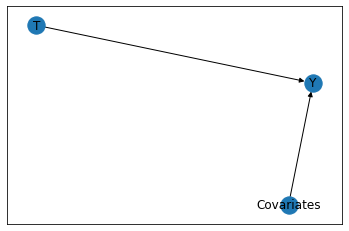

In [77]:
graph = nx.DiGraph()
g = nx.DiGraph()
g.add_edges_from([("T", "Y"), ("Covariates", "Y")])
plt.tight_layout()
nx.draw_networkx(g, arrows=True)
plt.show()

In [78]:
# real life example: T is studying time, Covariates is current grade, Y is Exam score.

# FlagX = 1, ### Use only right covariates / Controlled covariates

In [131]:
tau = 2
p = 100
p0 = 50 #number of covariates in the DGP
corr = 0.5 
conf = False
flagX = 1
N = 1000
Q1Data = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
y = pd.DataFrame(Q1Data[0])
t = pd.DataFrame(Q1Data[1])
x = pd.DataFrame(Q1Data[2])
Q1Data=pd.concat([y,t,x],axis=1)
Q1Data.to_csv('Q1Data.csv')

In [ ]:
(nvalues1,tauhats1,sehats1,lb1,ub1) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

In [119]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf,flagX = 1)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 69.08it/s]


In [120]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.2497295150218061, RMSE=37.535687785263086, size=0.0595
N=1000: bias=0.4223635632821833, RMSE=11.6571490394545, size=0.047


# FlagX = 2, Use some right and wrong covariates / do not control covariates

In [ ]:
tau = 2
p = 100
p0 = 50 #number of covariates in the DGP
corr = 0.5 
conf = False
flagX = 2
Nrange = range(10,1000,2) # loop over N values
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

In [121]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf,flagX = 2)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 72.67it/s]


In [122]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-1.1188667679293993, RMSE=37.563685958083376, size=0.0645
N=1000: bias=-0.3616422957262245, RMSE=11.509700019915924, size=0.049


# 2. Simulate a DGP with a confounder (common cause)

$y_i = \tau*T_i+\beta'*x_i+e_i$

$T_i = \gamma*x_i$

where $x_i$ is the confounder

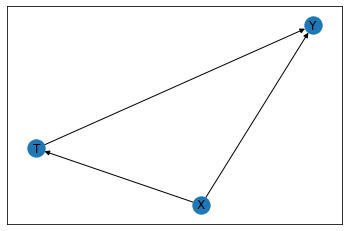

In [79]:
graph = nx.DiGraph()
g = nx.DiGraph()
g.add_edges_from([("T", "Y"), ("X", "Y"),("X","T")])
plt.tight_layout()
nx.draw_networkx(g, arrows=True)
plt.show()

In [136]:
tau = 2
p = 100
p0 = 50 
corr = 0.5 
N = 1000
Q2Data = fn_generate_data(tau,N,p,p0,corr,conf = True)
y = pd.DataFrame(Q2Data[0])
t = pd.DataFrame(Q2Data[1])
x = pd.DataFrame(Q2Data[2])
Q2Data=pd.concat([y,t,x],axis=1)
Q2Data.to_csv('Q2Data.csv')

UnboundLocalError: local variable 'conf_mult' referenced before assignment

# a. You fail to control for the confounder

In [84]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,100,50,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

  0%|                                                  | 0/2000 [00:00<?, ?it/s]


UnboundLocalError: local variable 'conf_mult' referenced before assignment

In [12]:
def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [ ]:
T = fn_randomize_treatment(N,p = 0.5)
err = np.random.normal(0,1,[N,1])
Yexp = tau*T+err

In [ ]:
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)